In [1]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from trainer import Trainer, TrainerConfig

import json
# for i in {1..10}; do python3 -m gather_atts.py; done

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)


set_seed(25)


In [2]:
DATASET = 'NaturalMovie'
DATASET = 'NaturalStim'



In [3]:
data_dir = "./data/NaturalMovie/"
data_dir = "./data/NaturalStim/"

if not os.path.exists(data_dir):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/1jgYBERZpXdbAP-E5xcSAHsWSa95Z9IFe?usp=sharing"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output="data/")


In [4]:
# load config files
import yaml

base_path = f"./models/tensorboard/NaturalStim/conv_[5, 16, 16]/sparse_f:None_id:None/w:0.05_wp:0.2/"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

# with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
#     dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
# dconf = OmegaConf.create(dconf)


In [5]:
frame_window = 0.25
window = 0.05
window_prev = 0.2
window_behavior = window
dt = 0.01
dt_frames = 0.05
dt_vars = 0.05
intervals = None
n_frames = frame_window // dt_frames



In [6]:
## choose modalities ##

# behavior
visual_stim = True



In [7]:
from neuroformer.SpikeVidUtils import trial_df_real, make_intervals
from neuroformer.prepare_data import load_natmovie_real

response_path = "././data/NaturalStim/20-NatureMovie_part1-A_spikes(1).mat"
stimulus_path = "././data/NaturalMovie/stimulus/docuMovie.pt"
df, stimulus = load_natmovie_real(response_path, stimulus_path, dt_frames)
for key, value in stimulus.items():
    stimulus[key] = value[0]

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']


In [8]:
# int_trials = df.groupby(['Interval', 'Trial']).size()
# print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
var_group = 'Interval'
n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
df.groupby([var_group, 'Trial']).size().sort_values(ascending=False).nlargest(int(0.7 * n_unique))
# df.groupby([var_group, 'Trial']).size().sort_values(ascending=False).nsmallest(int(0.99 * n_unique))



Interval  Trial
367.25    4        30
108.75    3        26
0.50      0        25
0.30      0        24
274.15    0        23
                   ..
200.30    1         3
459.20    4         3
173.25    3         3
          1         3
19.55     1         3
Length: 36260, dtype: int64

In [9]:
## resnet3d feats
n_embd = 256
n_embd_frames = 64
conv_layer = True

n_frames = round(frame_window * 1/dt_frames)
kernel_size = [n_frames, 16, 16]
stride_size = [n_frames, 8, 8]
padding_size = [0, 0, 0]
frame_block_size = ((20 // kernel_size[0] * 64 * 112) // (n_embd_frames))
frame_feats = stimulus if visual_stim else None
frame_block_size = (20 * 64 * 112) // (n_embd_frames)
# frame_block_size = 560
id_block_size = 33
prev_id_block_size = 100
id_block_size = prev_id_block_size   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }




In [10]:
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
test_trials = [3, 5]
# train_trials = random.sample(all_trials, int(len(all_trials) * r_split))
train_trials = [i for i in all_trials if i not in test_trials]
test_trials = [3, 5]

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[df['Trial'].isin(test_trials)]



In [11]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset=DATASET,
                                  )
test_dataset = train_dataset.copy(test_data)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')


Population Size:  1349
ID Population Size:  1349
DT Population Size:  23
train: 41754, test: 10014


In [12]:
loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)



In [13]:
x, y = next(iterable)


In [14]:
x, y = next(iterable)
# print(x['behavior'].shape, x['behavior_dt'].shape)
for k in x.keys():
    print(k, x[k].shape)



id_prev torch.Size([32, 100])
dt_prev torch.Size([32, 100])
pad_prev torch.Size([32])
id torch.Size([32, 100])
dt torch.Size([32, 100])
pad torch.Size([32])
interval torch.Size([32])
trial torch.Size([32])
frames torch.Size([32, 1, 5, 64, 112])
stimulus torch.Size([32])
cid torch.Size([32, 2])
pid torch.Size([32, 2])
f_idx torch.Size([32, 2])


In [15]:
from model_neuroformer import GPT, GPTConfig

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 300
batch_size = round((32 * 5))
shuffle = True

title =  f'contra_2/conv_{kernel_size}'

model_path = f"""./models/tensorboard/{DATASET}/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=mconf.n_stimulus_layers, self_att_layers=mconf.self_att_layers,
                        n_behavior_layers=0,
                        behavior_block_size=0,
                        predict_behavior=False,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=mconf.contrastive, clip_emb=1024, clip_temp=mconf.clip_temp,
                        conv_layer=conv_layer, 
                        kernel_size=kernel_size, stride_size=stride_size, padding_size=padding_size,
                        temp_emb=mconf.temp_emb, pos_emb=False,
                        wave_emb=True,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35

model = GPT(model_conf)
model.load_state_dict(torch.load(model_path))

573440
256 23


04/23/2023 18:58:55 - INFO - model_neuroformer -   number of parameters: 6.618926e+08


<All keys matched successfully>

In [17]:
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=2e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=0.2, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_every=1000)

# trainer = Trainer(model, None, test_dataset, tconf, model_conf)
# trainer.train()

In [19]:
from neuroformer.utils import predict_raster_recursive_time_auto, process_predictions

model.load_state_dict(torch.load(model_path))

results_dict = dict()
df_pred = None
df_true = None

top_p = 0.75
top_p_t = 0.75
temp = 1.25
temp_t = 1.25
max_interval = 5

trials = test_data['Trial'].unique()
for trial in trials:   
        print(f"Trial: {trial}")
        df_trial = df[(df['Trial'] == trial) & (df['Interval'] <= max_interval)]
        trial_dataset = SpikeTimeVidData2(df_trial,  None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset=DATASET,
                                  window_behavior=window_behavior)
        results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                           sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                           frame_end=0, get_dt=True, gpu=False, pred_dt=True)
        # results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
        # print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])


from neuroformer.analysis import compute_scores
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )


dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)
df_pred.to_csv(os.path.join(dir_name, F'df_pred_.csv'))

Trial: 3
Population Size:  1349
ID Population Size:  1349
DT Population Size:  23


len pred: 363, len true: 570: 100%|██████████| 95/95 [01:12<00:00,  1.31it/s]


pred: (311, 5), true: (570, 2)
Trial: 5
Population Size:  1349
ID Population Size:  1349
DT Population Size:  23


len pred: 356, len true: 600: 100%|██████████| 95/95 [01:11<00:00,  1.33it/s]


pred: (308, 5), true: (600, 2)
defaultdict(<class 'list'>, {'precision': 0.0026595744680851063, 'recall': 0.001000181851245681, 'F1': 0.0014441128333493789})
pred: 619, true: 1170


In [24]:
from analysis import get_rates_trial, calc_corr_psth
from neuroformer.SpikeVidUtils import set_intervals

df_1 = df[df['Trial'].isin(trials) & (df['Interval'] <= max_interval)]
df_pred_full = df_pred

window_pred = 0.5
min_window = window_prev + window
df_pred_full = set_intervals(df_pred_full, window, window_prev, window_pred)
df_1 = set_intervals(df_1, window, window_prev, window_pred)

window_pred = 0.5
window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)

len_pred: 619, len_true: 1011
pred: defaultdict(<class 'list'>, {'precision': 0.0633591166397174, 'recall': 0.04685271540404258, 'F1': 0.04990745464569367})
486


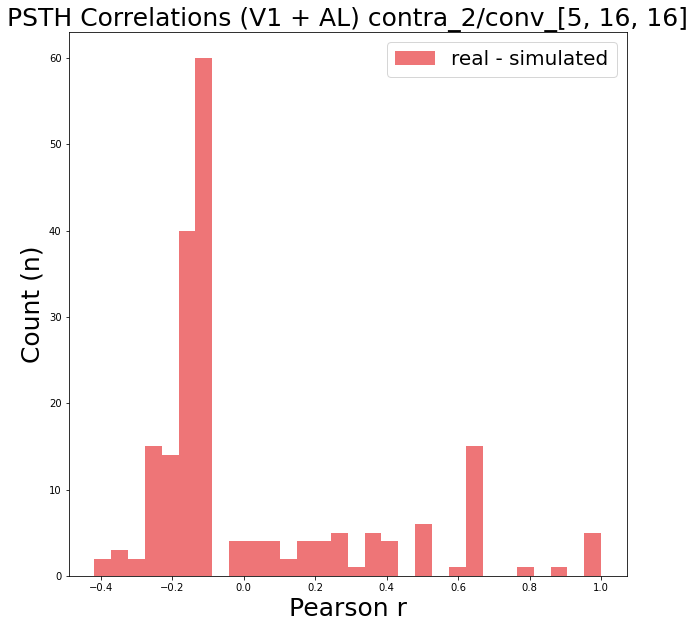

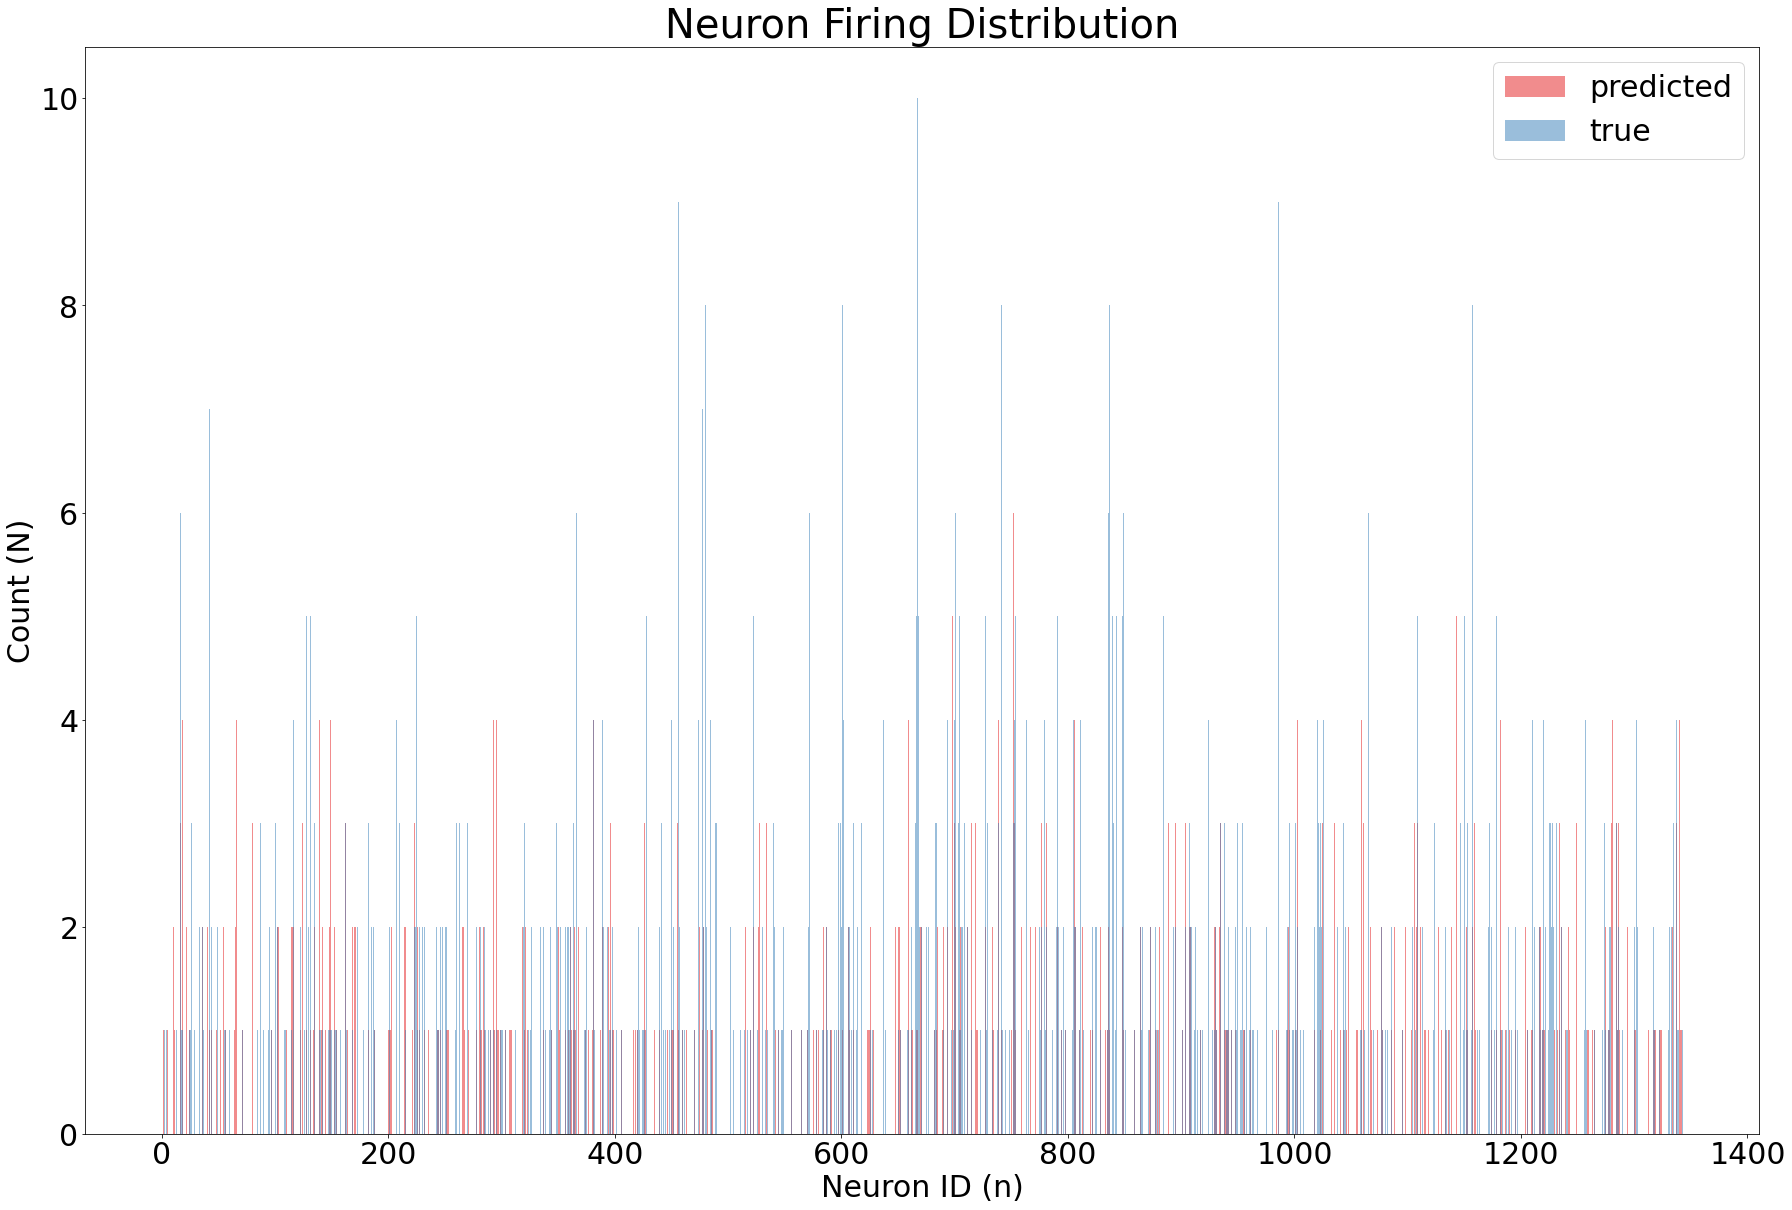

model: contra_2/conv_[5, 16, 16]


In [26]:
"""

Evaluate results

"""

from neuroformer.visualize import set_plot_white, plot_distribution
from neuroformer.analysis import get_accuracy, compute_scores


len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_1)
pred_scores = compute_scores(df_1, df_pred_full)

print(f"pred: {pred_scores}")

n_bins = 30
set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6, bins=30)
plt.legend(fontsize=20)

dir_name = os.path.dirname(model_path)

top_p = 0
save_title = f'_top_p{top_p}'
plt.savefig(os.path.join(dir_name, F'psth_corr_{save_title}_.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{save_title}_.csv'))

# also save true and pred scores as json dict
scores = dict()
scores['pred'] = pred_scores
with open(os.path.join(dir_name, F'scores_{save_title}_.txt'), 'w') as f:
    json.dump(pred_scores, f)


plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist_.svg'))

total_scores = dict()
total_scores['pred'] = pred_scores

print(f"model: {title}")


In [ ]:
x, y = next(iterable)

T = len(x['id'])
P = x['pad'] - 1
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")

print(f"xid_prev: {xid_prev}")

tdiff = 0
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

# t_var = 'Time' # 'Interval'
# int_var = 'pid'
# df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))]